In [1]:
import numpy as np          
import pandas as pd        
import scipy as sp          
import scipy.stats as stats
import scipy.optimize as op
import scipy.signal as sig
import statistics as stat
import os
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob           

from scipy.stats import gaussian_kde
from numpy import mean
from statistics import stdev
from numpy.fft import rfft, rfftfreq

import time
import sys
import math
import struct
%matplotlib inline

In [2]:
samplingRate = 1/60   #500000 = 500000  measurements per second, 1 measurement every 0.000002s

In [3]:
#################################################################################
#level 3 data here

In [4]:
#load level 3 data from  2020 and 2021
folder1_pattern = r"C:\Users\booker\projects\Schiltach\bf056-2\Level3\2020\IGETS-SG-RESMIN-bf056-2-2020*.txt"
folder2_pattern = r"C:\Users\booker\projects\Schiltach\bf056-2\Level3\2021\IGETS-SG-RESMIN-bf056-2-2021*.txt"

lev3_list = []

folder1_files = glob.glob(folder1_pattern)
for file_path in folder1_files:
    df = pd.read_csv(file_path, delim_whitespace=True, skiprows=19, names=["yyyymmdd", "hhmmss", "res_fil", "res_nofil", "tides", "rotation", "atm_load", "drift", "g_fil", "p_fil"])
    lev3_list.append(df)

folder2_files = glob.glob(folder2_pattern)
for file_path in folder2_files:
    df1 = pd.read_csv(file_path, delim_whitespace=True, skiprows=19, names=["yyyymmdd", "hhmmss", "res_fil", "res_nofil", "tides", "rotation", "atm_load", "drift", "g_fil", "p_fil"])
    lev3_list.append(df1)

lev3 = pd.concat(lev3_list, ignore_index=True)
df_bad_3 = lev3.loc[(lev3["p_fil"] == 'nan')| (lev3["g_fil"] == 'nan') | (lev3["hhmmss"] == 'nan')| (lev3["yyyymmdd"] == 99999999)|(lev3["yyyymmdd"] >= 20221231) ]#find bad column
bad_index_3 = df_bad_3.index.tolist()#make them into list
lev3 = lev3.drop(lev3.index[bad_index_3])#remove bad rows
lev3 = lev3.reset_index()

lev3['hours'] = lev3['hhmmss'] // 10000
lev3['minutes'] = (lev3['hhmmss'] // 100) % 100
lev3['seconds'] = lev3['hhmmss'] % 100


lev3['minutes_only'] = lev3['hours'] * 60 + lev3['minutes']
lev3['date'] = pd.to_datetime(lev3['yyyymmdd'], format='%Y%m%d')

starting_date = pd.to_datetime('20200101', format='%Y%m%d')#important !!!!!!!!!!!!!!

lev3['elapsed_minutes'] = (lev3['date'] - starting_date).dt.total_seconds() / 60
lev3['total_minutes']=lev3['elapsed_minutes']+lev3['minutes_only']
lev3['total_minutes_sec'] = lev3['total_minutes'] / 60

lev3['tot_g_no_p'] =lev3['atm_load']+ lev3['tides']+ lev3['rotation']+ lev3['drift']+ lev3['res_fil']
lev3['tot_g'] = lev3['atm_load']+ lev3['tides']+ lev3['rotation']+ lev3['drift']+ lev3['res_fil']+ lev3['p_fil']

#print things
lev3.head(3)
#lev3.to_csv('bfobfo2_2020a21_lev3_data.csv', index=False)  # Save the DataFrame to a CSV file!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

,index,yyyymmdd,hhmmss,res_fil,res_nofil,tides,rotation,atm_load,drift,g_fil,...,hours,minutes,seconds,minutes_only,date,elapsed_minutes,total_minutes,total_minutes_sec,tot_g_no_p,tot_g
0,0,20200101,100.0,29.252,29.252,-473.661,-5.964,-44.222,531.984,37.389,...,0.0,1.0,0.0,1.0,2020-01-01,0.0,1.0,0.016667,37.389,51.744
1,1,20200101,200.0,29.330,29.330,-476.680,-5.965,-44.153,531.985,34.517,...,0.0,2.0,0.0,2.0,2020-01-01,0.0,2.0,0.033333,34.517,48.845
2,2,20200101,300.0,29.406,29.406,-479.689,-5.965,-44.085,531.985,31.652,...,0.0,3.0,0.0,3.0,2020-01-01,0.0,3.0,0.050000,31.652,45.953


In [5]:
# PSD setup
g_fil = lev3['g_fil']  # compare to g_fil, just to make sure
N = len(g_fil)
samplingRate = 1 / 60  # once per min sampling rate
PSDG_g_fil = (np.abs(np.fft.rfft(g_fil)) ** 2) * 2 / (N * samplingRate)
freq_g_fil = np.fft.rfftfreq(N, d=1 / samplingRate)

Text(0, 0.5, 'Power spectral density (V^2/Hz)')

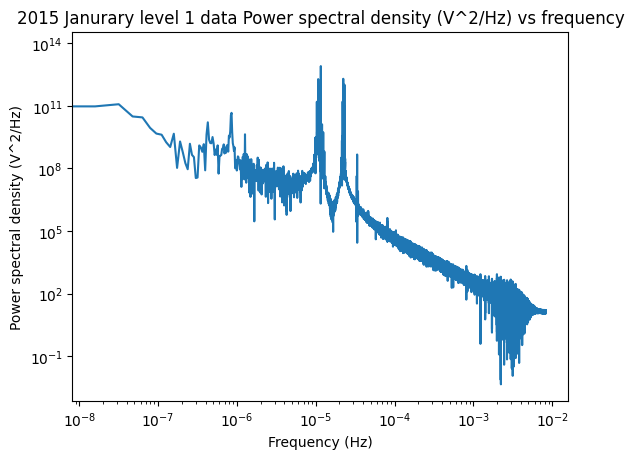

In [6]:
fig, ax = plt.subplots()
ax.plot(freq_g_fil, PSDG_g_fil)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_title('2015 Janurary level 1 data Power spectral density (V^2/Hz) vs frequency')

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power spectral density (V^2/Hz)')

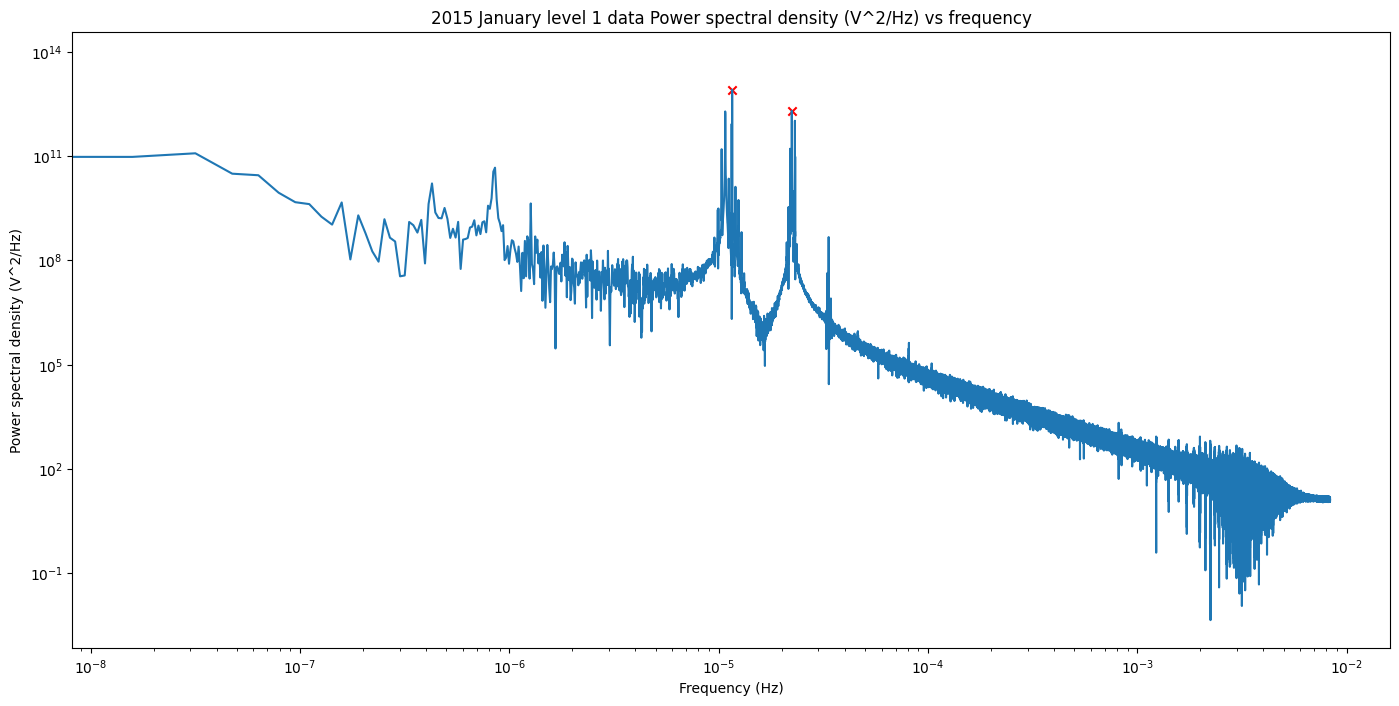

Top 10 Frequencies: [2.23569976e-05 1.16060051e-05 0.00000000e+00]
Top 10 PSDV values: [2.01812314e+12 8.18856643e+12 5.83947229e+13]


In [7]:
top_10_indices = np.argsort(PSDG_g_fil)[-3:]

top_10_PSDV = PSDG_g_fil[top_10_indices]
top_10_freq = freq_g_fil[top_10_indices]

fig, ax = plt.subplots(figsize=(17, 8))  # Added figsize here
ax.plot(freq_g_fil, PSDG_g_fil)
ax.scatter(top_10_freq, top_10_PSDV, color='red', marker='x')

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title('2015 January level 1 data Power spectral density (V^2/Hz) vs frequency')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power spectral density (V^2/Hz)')

plt.show()


print("Top 10 Frequencies:", top_10_freq)
print("Top 10 PSDV values:", top_10_PSDV)

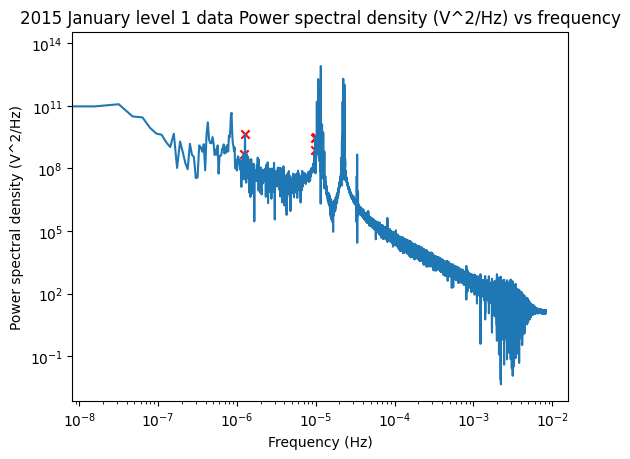

Top 3 Frequencies within range: [1.21918471e-06 9.89597979e-06 9.91181336e-06 9.97514763e-06
 1.26668541e-06]
Top 3 PSDV values within range: [4.93303760e+08 7.87034819e+08 2.87008681e+09 3.12718570e+09
 4.36727594e+09]


In [8]:
freq_min = 1e-6
freq_max = 1e-5
mask = (freq_g_fil >= freq_min) & (freq_g_fil <= freq_max)

filtered_freq = freq_g_fil[mask]
filtered_PSDG = PSDG_g_fil[mask]
top_3_indices = np.argsort(filtered_PSDG)[-5:]
top_3_PSDV = filtered_PSDG[top_3_indices]
top_3_freq = filtered_freq[top_3_indices]

fig, ax = plt.subplots()
ax.plot(freq_g_fil, PSDG_g_fil)
ax.scatter(top_3_freq, top_3_PSDV, color='red', marker='x')  

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title('2015 January level 1 data Power spectral density (V^2/Hz) vs frequency')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power spectral density (V^2/Hz)')

plt.show()

print("Top 3 Frequencies within range:", top_3_freq)
print("Top 3 PSDV values within range:", top_3_PSDV)

In [9]:
import numpy as np

# Frequencies in Hz
frequencies_hz = [2.24396374e-05, 1.15938126e-05]

# Convert frequencies to periods in hours
periods_hours = [1 / (freq * 3600) for freq in frequencies_hz]

print("Periods in hours:", periods_hours)

Periods in hours: [12.378888875351336, 23.95913987584876]


Text(0, 0.5, 'Power spectral density $dB (m/s^{2})^{2}/Hz$')

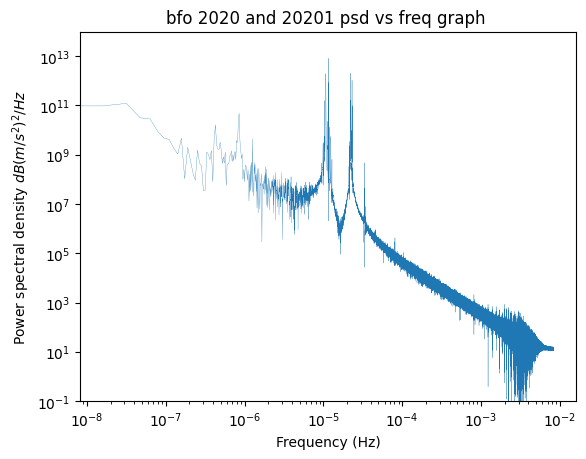

In [10]:
fig, ax = plt.subplots()
ax.plot(freq_g_fil, PSDG_g_fil, linewidth=0.2)
#ax.plot([2.777e-4, 2.777e-4], [-50, -250], 'k-', lw=1,dashes=[4, 4])
#ax.plot([0.02, 0.02], [-50, -250], 'k-', lw=1,dashes=[4, 4])
ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_xlim(1e-4,1e-2)
ax.set_ylim(1e-1,1e14)
ax.set_title('bfo 2020 and 20201 psd vs freq graph ')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power spectral density $dB (m/s^{2})^{2}/Hz$')

In [11]:
atm_load_p =[1.2102413946392654,12.785580990160629,25.164825129155492,0.0010445868417927092,0.5704552964862316,0.32507363597782224]
tides_p =[10.474787111955616,75.06968638762876,69.7405974959026,99.99790765668479,94.33178168544177,91.61685030711287]
rotation_p =[6.074381061379024,0.017276859670238766,0.002674999369260476,4.1156910491804936e-07,0.0019665258643712913,0.002004491507940261]
drift_p =[71.5432838163522,10.532310326090426,4.428848675517263,0.000947011426072079,4.532000509841386,4.597294669951505]
res_fil_p =[10.69730661567389,1.5951454364499487,0.6630537000553695,0.00010033347824984256,0.563795982366245,3.458776895449842]
#freq_ax = [4.5e-8,4.5e-7,4.5e-6,4.5e-5,0.00045,0.0045]
freq_ax = [10**-7.5,10**-6.5,10**-5.5,10**-4.5,10**-3.5,10**-2.5]

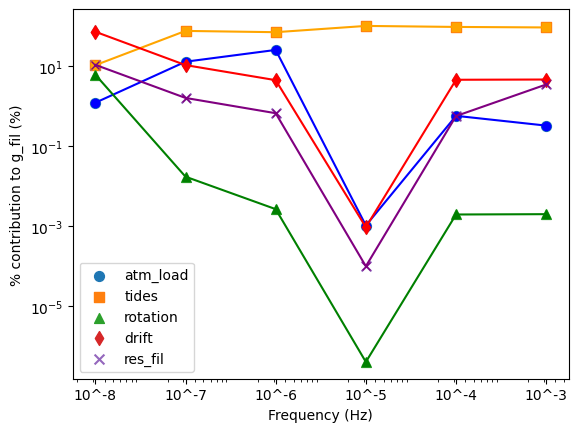

In [12]:
#plt.figure(figsize=(6, 6))

# Create the point graph
plt.scatter(freq_ax, atm_load_p, label='atm_load', s=50, marker='o')
plt.scatter(freq_ax, tides_p, label='tides', s=50, marker='s')
plt.scatter(freq_ax, rotation_p, label='rotation', s=50, marker='^')
plt.scatter(freq_ax, drift_p, label='drift', s=50, marker='d')
plt.scatter(freq_ax, res_fil_p, label='res_fil', s=50, marker='x')

# Create lines connecting the points
plt.plot(freq_ax, atm_load_p, color='blue', linestyle='-', marker='o')
plt.plot(freq_ax, tides_p, color='orange', linestyle='-', marker='s')
plt.plot(freq_ax, rotation_p, color='green', linestyle='-', marker='^')
plt.plot(freq_ax, drift_p, color='red', linestyle='-', marker='d')
plt.plot(freq_ax, res_fil_p, color='purple', linestyle='-', marker='x')

# Set labels and title
plt.xlabel('Frequency (Hz)')
plt.ylabel('% contribution to g_fil (%)')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xticks(freq_ax, ['10^-8', '10^-7', '10^-6', '10^-5', '10^-4', '10^-3'])

plt.show()

In [13]:
max_x= [2.23569976e-05, 1.16060051e-05, 4.27506327e-07, 4.62656847e-05]
max_y= [2.01812314e+12, 8.18856643e+12, 1.64353147e+10, 919013.77263232]

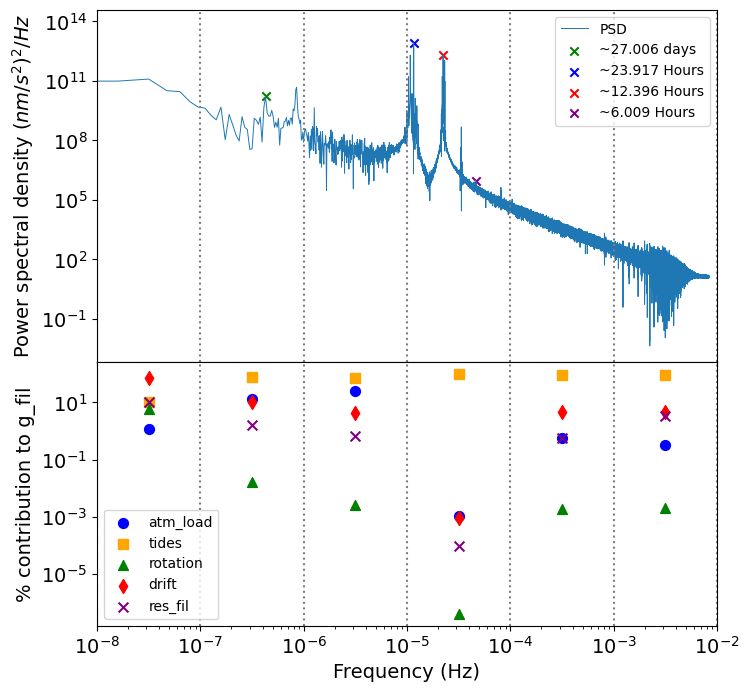

In [14]:
# Calculate midpoints between each pair of adjacent values in freq_ax
freq_ax_midpoints = [np.sqrt(freq_ax[i] * freq_ax[i+1]) for i in range(len(freq_ax)-1)]

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1.5]})
ax1.plot(freq_g_fil, PSDG_g_fil, linewidth=0.7, label='PSD')
#plot the two max
ax1.scatter(max_x[2], max_y[2], color='green', marker='x', label='~27.006 days')
ax1.scatter(max_x[1], max_y[1], color='blue', marker='x', label='~23.917 Hours')
ax1.scatter(max_x[0], max_y[0], color='red', marker='x', label='~12.396 Hours')
ax1.scatter(max_x[3], max_y[3], color='purple', marker='x', label='~6.009 Hours')
ax1.legend()

ax2.scatter(freq_ax, atm_load_p, label='atm_load', s=50, marker='o', color='blue')
ax2.scatter(freq_ax, tides_p, label='tides', s=50, marker='s', color='orange')
ax2.scatter(freq_ax, rotation_p, label='rotation', s=50, marker='^', color='green')
ax2.scatter(freq_ax, drift_p, label='drift', s=50, marker='d', color='red')
ax2.scatter(freq_ax, res_fil_p, label='res_fil', s=50, marker='x', color='purple')

ax2.set_yscale('log')
ax2.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.set_xticks([])
ax1.set_ylabel('Power spectral density $(nm/s^{2})^{2}/Hz$', fontsize=14)

ax2.set_xlabel('Frequency (Hz)', fontsize=14)
ax2.set_ylabel('% contribution to g_fil', fontsize=14)
ax2.legend()

ax2.set_xticks(freq_ax_midpoints + [0.001, 0.01])  # Add 10^-2 and 10^-3 midpoints
ax2.set_xticklabels(['$10^{-8}$', '$10^{-7}$', '$10^{-6}$', '$10^{-5}$', '$10^{-4}$', '$10^{-3}$', '$10^{-2}$'])

ax2.label_outer()

# List of the desired x-axis positions
# Set x-axis ticks and labels
x_positions = [10**-8, 10**-7, 10**-6, 10**-5, 10**-4, 10**-3, 10**-2]
labels = ['$10^{-8}$', '$10^{-7}$', '$10^{-6}$', '$10^{-5}$', '$10^{-4}$', '$10^{-3}$', '$10^{-2}$']

ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)

ax2.set_xticks(x_positions)
ax2.set_xticklabels(labels)
ax2.set_xlim([10**-8, 10**-2])  # Set x-axis limits
# Adding dotted lines at the desired positions
for freq_value in x_positions:
    ax2.axvline(freq_value, color='gray', linestyle='dotted')
    ax1.axvline(freq_value, color='gray', linestyle='dotted')

plt.subplots_adjust(hspace=0)

plt.show()

In [15]:
freq_ax[1]

3.162277660168379e-07

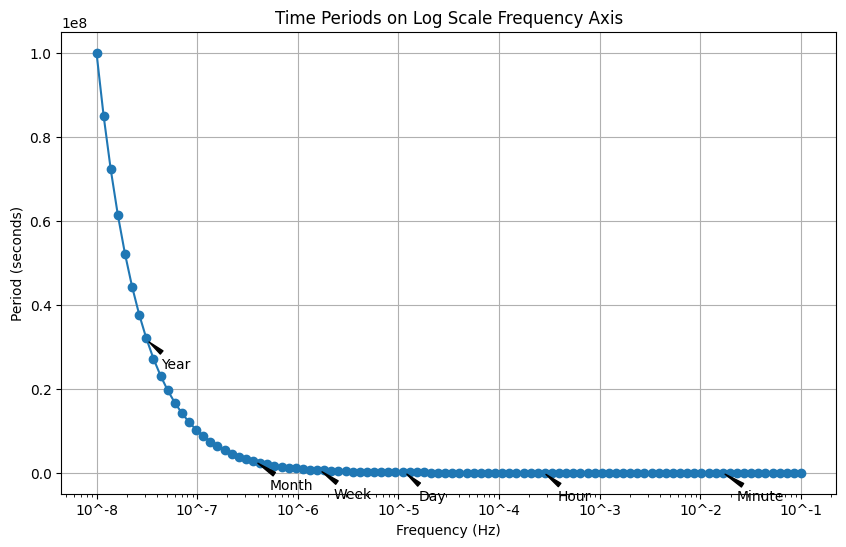

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Define the frequencies in log scale (Hz)
frequencies = np.logspace(-8, -1, num=100)

# Calculate the corresponding periods in seconds
periods = 1 / frequencies

# Define the time units for labeling the points
time_units = ['Month', 'Year', 'Week', 'Day', 'Hour', 'Minute']

# Define the corresponding time periods for each unit
time_values = [2.628e6, 3.154e7, 6.048e5, 8.64e4, 3.6e3, 60]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(frequencies, periods, marker='o')

# Annotate the points with time units
for unit, value in zip(time_units, time_values):
    plt.annotate(unit, xy=(1/value, value), xytext=(10, -20), textcoords='offset points', arrowprops=dict(facecolor='black', arrowstyle='wedge'))

# Set x-axis to log scale and add labels
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Period (seconds)')
plt.title('Time Periods on Log Scale Frequency Axis')

# Set x-axis tick labels
xtick_labels = ['10^-8', '10^-7', '10^-6', '10^-5', '10^-4', '10^-3', '10^-2', '10^-1']
xtick_positions = [10**-8, 10**-7, 10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1]
plt.xticks(xtick_positions, xtick_labels)

# Display the plot
plt.grid(True)
plt.show()

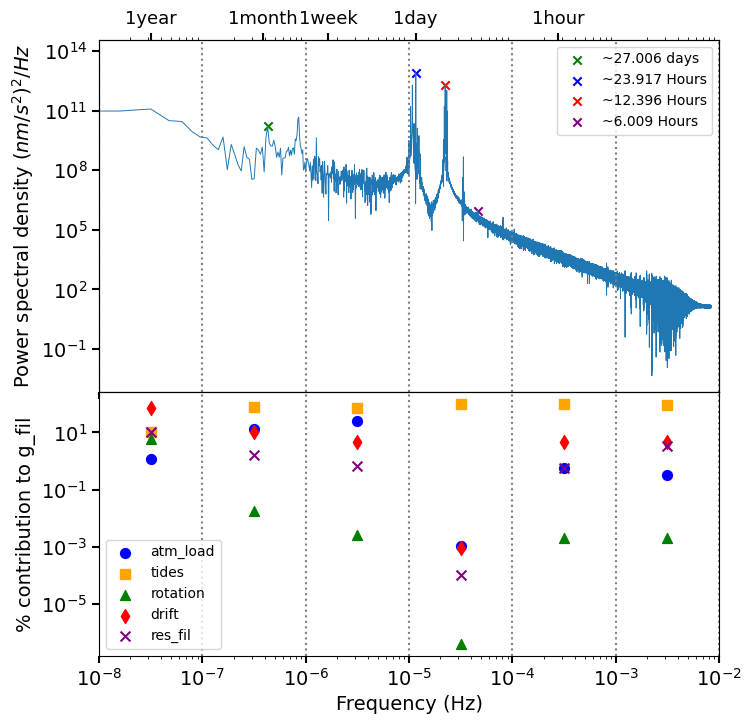

In [17]:
# Calculate midpoints between each pair of adjacent values in freq_ax
freq_ax_midpoints = [np.sqrt(freq_ax[i] * freq_ax[i+1]) for i in range(len(freq_ax)-1)]

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1.5]})
ax1.plot(freq_g_fil, PSDG_g_fil, linewidth=0.7)
#plot the two max
ax1.scatter(max_x[2], max_y[2], color='green', marker='x', label='~27.006 days')
ax1.scatter(max_x[1], max_y[1], color='blue', marker='x', label='~23.917 Hours')
ax1.scatter(max_x[0], max_y[0], color='red', marker='x', label='~12.396 Hours')
ax1.scatter(max_x[3], max_y[3], color='purple', marker='x', label='~6.009 Hours')
ax1.legend()

ax2.scatter(freq_ax, atm_load_p, label='atm_load', s=50, marker='o', color='blue')
ax2.scatter(freq_ax, tides_p, label='tides', s=50, marker='s', color='orange')
ax2.scatter(freq_ax, rotation_p, label='rotation', s=50, marker='^', color='green')
ax2.scatter(freq_ax, drift_p, label='drift', s=50, marker='d', color='red')
ax2.scatter(freq_ax, res_fil_p, label='res_fil', s=50, marker='x', color='purple')

ax2.set_yscale('log')
ax2.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.set_xticks([])
ax1.set_ylabel('Power spectral density $(nm/s^{2})^{2}/Hz$', fontsize=14)

ax2.set_xlabel('Frequency (Hz)', fontsize=14)
ax2.set_ylabel('% contribution to g_fil', fontsize=14)
ax2.legend()

ax2.set_xticks(freq_ax_midpoints + [0.001, 0.01])  # Add 10^-2 and 10^-3 midpoints
ax2.set_xticklabels(['$10^{-8}$', '$10^{-7}$', '$10^{-6}$', '$10^{-5}$', '$10^{-4}$', '$10^{-3}$', '$10^{-2}$'])

ax2.label_outer()

# List of the desired x-axis positions
# Set x-axis ticks and labels
x_positions = [10**-8, 10**-7, 10**-6, 10**-5, 10**-4, 10**-3, 10**-2]
labels = ['$10^{-8}$', '$10^{-7}$', '$10^{-6}$', '$10^{-5}$', '$10^{-4}$', '$10^{-3}$', '$10^{-2}$']

ax1.tick_params(axis='both', which='major', labelsize=14, length=5, width=1.5)
ax2.tick_params(axis='both', which='major', labelsize=14, length=5, width=1.5)

ax2.set_xticks(x_positions)
ax2.set_xticklabels(labels)
ax2.set_xlim([10**-8, 10**-2])  # Set x-axis limits
# Adding dotted lines at the desired positions
for freq_value in x_positions:
    ax2.axvline(freq_value, color='gray', linestyle='dotted')
    ax1.axvline(freq_value, color='gray', linestyle='dotted')

plt.subplots_adjust(hspace=0)

# Create a twin axis for the top of the plot
ax1_twin = ax1.twiny()

# Calculate frequencies for 1 year, 1 month, 1 week, 1 day, 1 hour, and 1 minute
one_year = 1 / (365.25 * 24 * 3600)
one_month = 1 / (30 * 24 * 3600)
one_week = 1 / (7 * 24 * 3600)
one_day = 1 / (24 * 3600)
one_hour = 1 / 3600
one_minute = 1 / 60

# Set the x-positions and labels for the twin axis
x_positions_twin = [one_year, one_month, one_week, one_day, one_hour, one_minute]
labels_twin = ['1year', '1month', '1week', '1day', '1hour', '1minute']

# Set log scale and labels for the twin axis
ax1_twin.set_xscale('log')
ax1_twin.set_xticks(x_positions_twin)
ax1_twin.set_xticklabels(labels_twin)

ax1_twin.tick_params(axis='both', which='major', labelsize=13, length=5, width=1.5)

ax1_twin.set_xlim(ax1.get_xlim())  # Make sure the twin axis has the same limits as the original axis

plt.subplots_adjust(hspace=0)
plt.show()

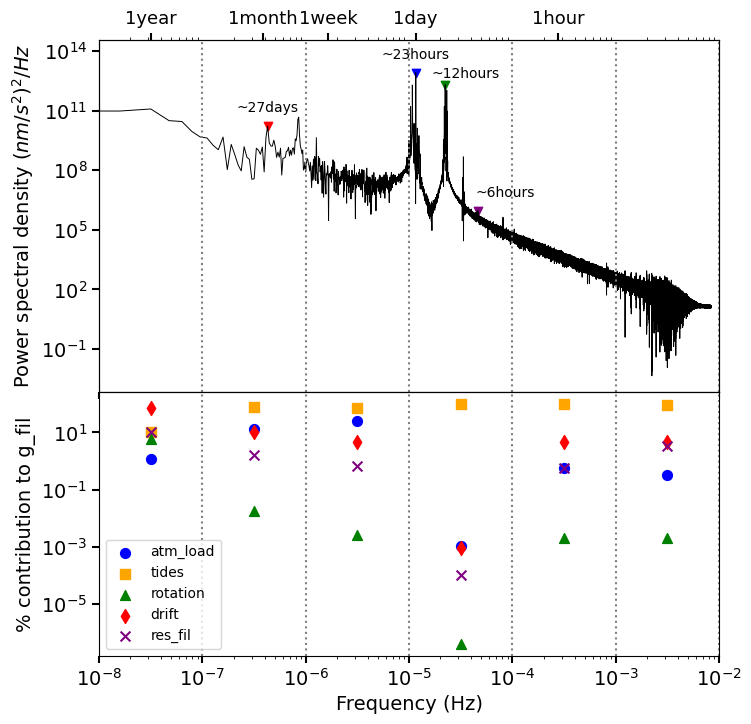

In [18]:
# Calculate midpoints between each pair of adjacent values in freq_ax
freq_ax_midpoints = [np.sqrt(freq_ax[i] * freq_ax[i+1]) for i in range(len(freq_ax)-1)]

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1.5]})
ax1.plot(freq_g_fil, PSDG_g_fil, linewidth=0.7, color='black')
#plot the two max
markers = ['v', 'v', 'v', 'v']
colors = ['green', 'blue', 'red', 'purple']
labels = ['~12hours', '~23hours', '~27days', '~6hours']
offsets = [(15, 5), (0, 10), (0, 10), (20, 10)]  # Added an offset list; the last one moves 20 points to the right

for i, (x, y, marker, color, label, offset) in enumerate(zip(max_x, max_y, markers, colors, labels, offsets)):
    ax1.scatter(x, y, color=color, marker=marker)
    ax1.annotate(label,
                 (x, y),
                 textcoords="offset points",
                 xytext=offset,
                 ha='center')

ax2.scatter(freq_ax, atm_load_p, label='atm_load', s=50, marker='o', color='blue')
ax2.scatter(freq_ax, tides_p, label='tides', s=50, marker='s', color='orange')
ax2.scatter(freq_ax, rotation_p, label='rotation', s=50, marker='^', color='green')
ax2.scatter(freq_ax, drift_p, label='drift', s=50, marker='d', color='red')
ax2.scatter(freq_ax, res_fil_p, label='res_fil', s=50, marker='x', color='purple')

ax2.set_yscale('log')
ax2.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.set_xticks([])
ax1.set_ylabel('Power spectral density $(nm/s^{2})^{2}/Hz$', fontsize=14)

ax2.set_xlabel('Frequency (Hz)', fontsize=14)
ax2.set_ylabel('% contribution to g_fil', fontsize=14)
ax2.legend()

ax2.set_xticks(freq_ax_midpoints + [0.001, 0.01])  # Add 10^-2 and 10^-3 midpoints
ax2.set_xticklabels(['$10^{-8}$', '$10^{-7}$', '$10^{-6}$', '$10^{-5}$', '$10^{-4}$', '$10^{-3}$', '$10^{-2}$'])

ax2.label_outer()

# List of the desired x-axis positions
# Set x-axis ticks and labels
x_positions = [10**-8, 10**-7, 10**-6, 10**-5, 10**-4, 10**-3, 10**-2]
labels = ['$10^{-8}$', '$10^{-7}$', '$10^{-6}$', '$10^{-5}$', '$10^{-4}$', '$10^{-3}$', '$10^{-2}$']

ax1.tick_params(axis='both', which='major', labelsize=14, length=5, width=1.5)
ax2.tick_params(axis='both', which='major', labelsize=14, length=5, width=1.5)

ax2.set_xticks(x_positions)
ax2.set_xticklabels(labels)
ax2.set_xlim([10**-8, 10**-2])  # Set x-axis limits
# Adding dotted lines at the desired positions
for freq_value in x_positions:
    ax2.axvline(freq_value, color='gray', linestyle='dotted')
    ax1.axvline(freq_value, color='gray', linestyle='dotted')

plt.subplots_adjust(hspace=0)

# Create a twin axis for the top of the plot
ax1_twin = ax1.twiny()

# Calculate frequencies for 1 year, 1 month, 1 week, 1 day, 1 hour, and 1 minute
one_year = 1 / (365.25 * 24 * 3600)
one_month = 1 / (30 * 24 * 3600)
one_week = 1 / (7 * 24 * 3600)
one_day = 1 / (24 * 3600)
one_hour = 1 / 3600
one_minute = 1 / 60

# Set the x-positions and labels for the twin axis
x_positions_twin = [one_year, one_month, one_week, one_day, one_hour, one_minute]
labels_twin = ['1year', '1month', '1week', '1day', '1hour', '1minute']

# Set log scale and labels for the twin axis
ax1_twin.set_xscale('log')
ax1_twin.set_xticks(x_positions_twin)
ax1_twin.set_xticklabels(labels_twin)

ax1_twin.tick_params(axis='both', which='major', labelsize=13, length=5, width=1.5)

ax1_twin.set_xlim(ax1.get_xlim())  # Make sure the twin axis has the same limits as the original axis

plt.subplots_adjust(hspace=0)
plt.show()

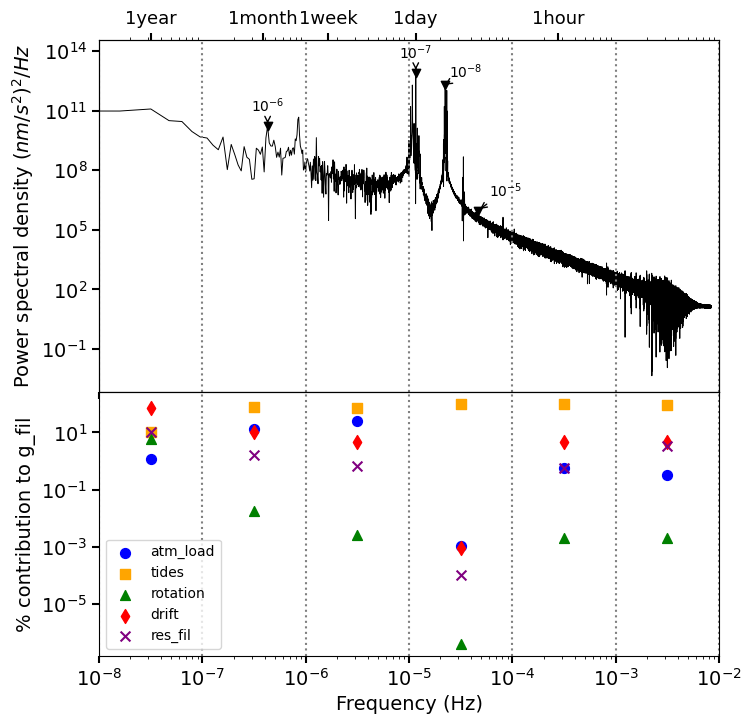

In [19]:
# Calculate midpoints between each pair of adjacent values in freq_ax
freq_ax_midpoints = [np.sqrt(freq_ax[i] * freq_ax[i+1]) for i in range(len(freq_ax)-1)]

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1.5]})
ax1.plot(freq_g_fil, PSDG_g_fil, linewidth=0.7, color='black')

# Plot the peaks with arrows
for i, (x, y, label, offset) in enumerate(zip(max_x, max_y, labels, offsets)):
    ax1.scatter(x, y, color='black', marker='v')  # Set marker color to black
    ax1.annotate(label,
                 (x, y),
                 textcoords="offset points",
                 xytext=offset,
                 ha='center',
                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0"))  # Arrow properties added

ax2.scatter(freq_ax, atm_load_p, label='atm_load', s=50, marker='o', color='blue')
ax2.scatter(freq_ax, tides_p, label='tides', s=50, marker='s', color='orange')
ax2.scatter(freq_ax, rotation_p, label='rotation', s=50, marker='^', color='green')
ax2.scatter(freq_ax, drift_p, label='drift', s=50, marker='d', color='red')
ax2.scatter(freq_ax, res_fil_p, label='res_fil', s=50, marker='x', color='purple')

ax2.set_yscale('log')
ax2.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.set_xticks([])
ax1.set_ylabel('Power spectral density $(nm/s^{2})^{2}/Hz$', fontsize=14)

ax2.set_xlabel('Frequency (Hz)', fontsize=14)
ax2.set_ylabel('% contribution to g_fil', fontsize=14)
ax2.legend()

ax2.set_xticks(freq_ax_midpoints + [0.001, 0.01])
ax2.set_xticklabels(['$10^{-8}$', '$10^{-7}$', '$10^{-6}$', '$10^{-5}$', '$10^{-4}$', '$10^{-3}$', '$10^{-2}$'])

ax2.label_outer()

x_positions = [10**-8, 10**-7, 10**-6, 10**-5, 10**-4, 10**-3, 10**-2]

ax1.tick_params(axis='both', which='major', labelsize=14, length=5, width=1.5)
ax2.tick_params(axis='both', which='major', labelsize=14, length=5, width=1.5)

ax2.set_xticks(x_positions)
ax2.set_xticklabels(labels)
ax2.set_xlim([10**-8, 10**-2])

for freq_value in x_positions:
    ax2.axvline(freq_value, color='gray', linestyle='dotted')
    ax1.axvline(freq_value, color='gray', linestyle='dotted')

plt.subplots_adjust(hspace=0)

ax1_twin = ax1.twiny()

one_year = 1 / (365.25 * 24 * 3600)
one_month = 1 / (30 * 24 * 3600)
one_week = 1 / (7 * 24 * 3600)
one_day = 1 / (24 * 3600)
one_hour = 1 / 3600
one_minute = 1 / 60

x_positions_twin = [one_year, one_month, one_week, one_day, one_hour, one_minute]
labels_twin = ['1year', '1month', '1week', '1day', '1hour', '1minute']

ax1_twin.set_xscale('log')
ax1_twin.set_xticks(x_positions_twin)
ax1_twin.set_xticklabels(labels_twin)

ax1_twin.tick_params(axis='both', which='major', labelsize=13, length=5, width=1.5)

ax1_twin.set_xlim(ax1.get_xlim())

plt.subplots_adjust(hspace=0)
plt.show()

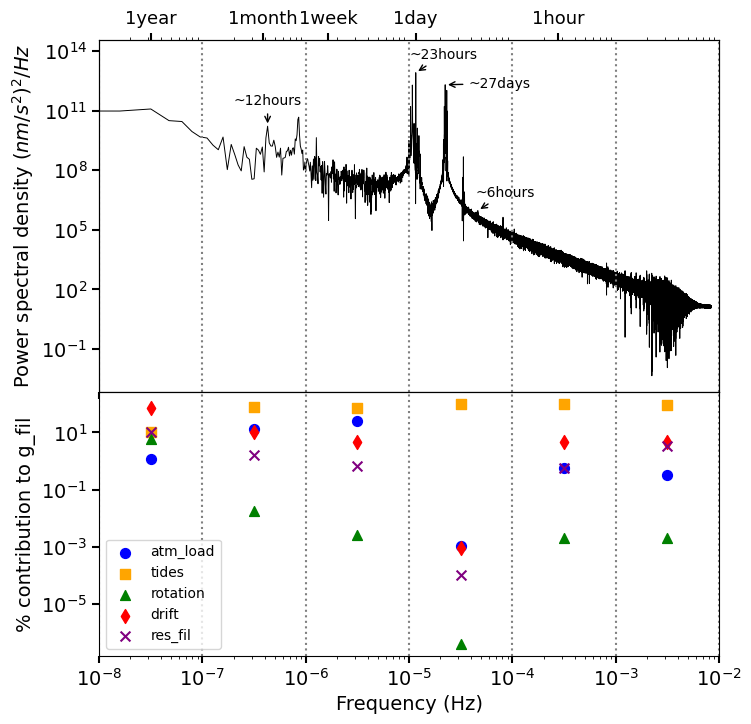

In [21]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1.5]})
ax1.plot(freq_g_fil, PSDG_g_fil, linewidth=0.7, color='black')

# Define your offsets here
offsets = [(39, -2), (20, 10), (0, 15), (20, 10)]
peak_labels = ['~27days', '~23hours', '~12hours', '~6hours']
# Plot the labels with arrows without triangles
for i, (x, y, label, offset) in enumerate(zip(max_x, max_y, peak_labels, offsets)):
    ax1.annotate(label,
                 (x, y),
                 textcoords="offset points",
                 xytext=offset,
                 ha='center',
                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0"))

ax2.scatter(freq_ax, atm_load_p, label='atm_load', s=50, marker='o', color='blue')
ax2.scatter(freq_ax, tides_p, label='tides', s=50, marker='s', color='orange')
ax2.scatter(freq_ax, rotation_p, label='rotation', s=50, marker='^', color='green')
ax2.scatter(freq_ax, drift_p, label='drift', s=50, marker='d', color='red')
ax2.scatter(freq_ax, res_fil_p, label='res_fil', s=50, marker='x', color='purple')

ax2.set_yscale('log')
ax2.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.set_xticks([])
ax1.set_ylabel('Power spectral density $(nm/s^{2})^{2}/Hz$', fontsize=14)

ax2.set_xlabel('Frequency (Hz)', fontsize=14)
ax2.set_ylabel('% contribution to g_fil', fontsize=14)
ax2.legend()

ax2.set_xticks(freq_ax_midpoints + [0.001, 0.01])
ax2.set_xticklabels(['$10^{-8}$', '$10^{-7}$', '$10^{-6}$', '$10^{-5}$', '$10^{-4}$', '$10^{-3}$', '$10^{-2}$'])

ax2.label_outer()

x_positions = [10**-8, 10**-7, 10**-6, 10**-5, 10**-4, 10**-3, 10**-2]

ax1.tick_params(axis='both', which='major', labelsize=14, length=5, width=1.5)
ax2.tick_params(axis='both', which='major', labelsize=14, length=5, width=1.5)

ax2.set_xticks(x_positions)
ax2.set_xticklabels(labels)
ax2.set_xlim([10**-8, 10**-2])

for freq_value in x_positions:
    ax2.axvline(freq_value, color='gray', linestyle='dotted')
    ax1.axvline(freq_value, color='gray', linestyle='dotted')

plt.subplots_adjust(hspace=0)

ax1_twin = ax1.twiny()

one_year = 1 / (365.25 * 24 * 3600)
one_month = 1 / (30 * 24 * 3600)
one_week = 1 / (7 * 24 * 3600)
one_day = 1 / (24 * 3600)
one_hour = 1 / 3600
one_minute = 1 / 60

x_positions_twin = [one_year, one_month, one_week, one_day, one_hour, one_minute]
labels_twin = ['1year', '1month', '1week', '1day', '1hour', '1minute']

ax1_twin.set_xscale('log')
ax1_twin.set_xticks(x_positions_twin)
ax1_twin.set_xticklabels(labels_twin)

ax1_twin.tick_params(axis='both', which='major', labelsize=13, length=5, width=1.5)

ax1_twin.set_xlim(ax1.get_xlim())

plt.subplots_adjust(hspace=0)
plt.show()